# Level 1: Baseline Model (Flowers-102)

**Objective**: Build a baseline classifier using transfer learning (ResNet50) with >85% accuracy.

**Dataset**: FLOWERS-102
**Split**: 80% Train, 10% Val, 10% Test (Custom split implementation to fix official dataset imbalance).

In [ ]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Data Loading & Preprocessing
We merge the official Train (1020), Val (1020), and Test (6149) splits and re-split them to achieving a standard **80-10-10** distribution for Deep Learning.

In [ ]:
class MergedFlowersDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.loader = datasets.folder.default_loader

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        path = self.image_files[idx]
        target = self.labels[idx]
        sample = self.loader(path)
        if self.transform:
            sample = self.transform(sample)
        return sample, target

def get_flowers102_dataloaders(root='./data', batch_size=32, num_workers=0, download=True):
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'test': transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

    print("Loading Flowers102 dataset (merging official splits)...")
    all_samples = []
    all_labels = []
    
    for split in ['train', 'val', 'test']:
        try:
             ds = datasets.Flowers102(root=root, split=split, download=download)
             all_samples.extend(ds._image_files)
             all_labels.extend(ds._labels)
        except RuntimeError as e:
             print(f"Error loading split {split}: {e}")
             pass
        
    print(f"Total images found: {len(all_samples)}")
    
    if len(all_samples) == 0:
        raise ValueError("No images found! Check internet connection or download rights.")

    indices = np.arange(len(all_samples))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, shuffle=True, random_state=42, stratify=all_labels)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, shuffle=True, random_state=42, stratify=np.array(all_labels)[temp_idx])
    
    print(f"Split sizes -> Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
    
    datasets_dict = {
        'train': MergedFlowersDataset([all_samples[i] for i in train_idx], [all_labels[i] for i in train_idx], transform=data_transforms['train']),
        'val': MergedFlowersDataset([all_samples[i] for i in val_idx], [all_labels[i] for i in val_idx], transform=data_transforms['val']),
        'test': MergedFlowersDataset([all_samples[i] for i in test_idx], [all_labels[i] for i in test_idx], transform=data_transforms['test'])
    }

    dataloaders = {
        x: DataLoader(datasets_dict[x], batch_size=batch_size, shuffle=(x=='train'), num_workers=num_workers)
        for x in ['train', 'val', 'test']
    }
    
    dataset_sizes = {x: len(datasets_dict[x]) for x in ['train', 'val', 'test']}
    return dataloaders, dataset_sizes

dataloaders, dataset_sizes = get_flowers102_dataloaders(num_workers=0)

Loading Flowers102 dataset (merging official splits)...
Total images found: 8189
Split sizes -> Train: 6551, Val: 819, Test: 819


## 2. Model Setup (ResNet50)
Using Transfer Learning: Freezing the backbone and training only the final classification layer.

In [3]:
def build_model():
    model = models.resnet50(pretrained=True)
    
    # Freeze backbone
    for param in model.parameters():
        param.requires_grad = False
        
    # Replace Head
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    
    model = model.to(device)
    return model

model = build_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

c:\Users\sansk\PROJECTS\terafac\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sansk\PROJECTS\terafac\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 3. Training Loop

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    story = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                story['train_loss'].append(epoch_loss)
                story['train_acc'].append(epoch_acc.item())
            else:
                story['val_loss'].append(epoch_loss)
                story['val_acc'].append(epoch_acc.item())
                
    return model, story

model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

Epoch 1/10
train Loss: 3.9494 Acc: 0.2018
val Loss: 3.2501 Acc: 0.4225
Epoch 2/10
train Loss: 2.8173 Acc: 0.5004
val Loss: 2.3627 Acc: 0.5812
Epoch 3/10
train Loss: 2.1183 Acc: 0.6724
val Loss: 1.8430 Acc: 0.6886
Epoch 4/10
train Loss: 1.6606 Acc: 0.7722
val Loss: 1.4883 Acc: 0.7778
Epoch 5/10
train Loss: 1.3539 Acc: 0.8272
val Loss: 1.2642 Acc: 0.8181
Epoch 6/10
train Loss: 1.1443 Acc: 0.8672
val Loss: 1.0870 Acc: 0.8425
Epoch 7/10
train Loss: 0.9849 Acc: 0.8912
val Loss: 0.9612 Acc: 0.8681
Epoch 8/10
train Loss: 0.8659 Acc: 0.9018
val Loss: 0.8477 Acc: 0.8877
Epoch 9/10
train Loss: 0.7722 Acc: 0.9148
val Loss: 0.7839 Acc: 0.8999
Epoch 10/10
train Loss: 0.7087 Acc: 0.9235
val Loss: 0.7197 Acc: 0.9011


## 4. Evaluation & Visualization

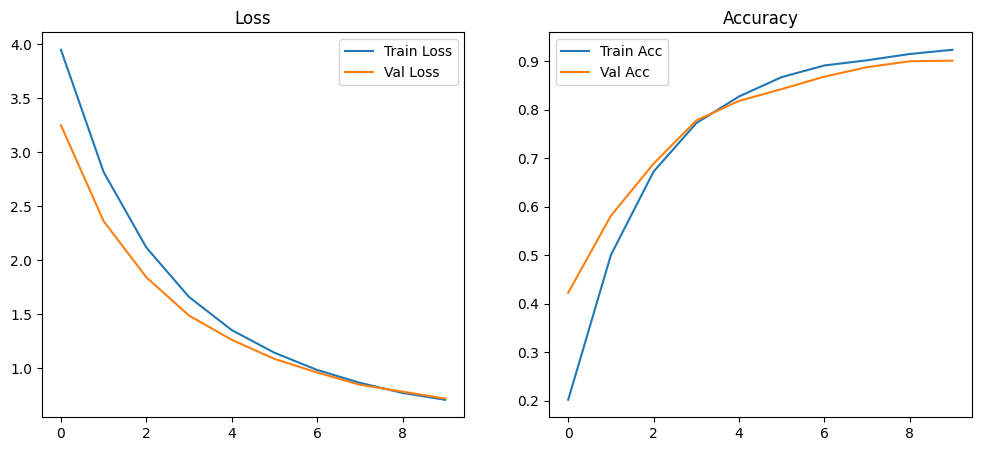

Final Test Accuracy: 0.9011


In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

print(f"Final Test Accuracy: {correct.double()/total:.4f}")